## Logistic Regression with L2 regularization
The goal of this assignment is to implement your own logistic regression classifier with L2 regularization. You will do the following:

Extract features from Amazon product reviews.

Convert an dataframe into a NumPy array.

Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.

Implement gradient ascent with an L2 penalty.

Empirically explore how the L2 penalty can ameliorate overfitting.

In [1]:
import pandas as pd
import numpy as np
import string
import json

In [2]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def readjson(path):
    try:
        with open(path,'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        raise FileNotFoundError( "Please check the path and try agaian!!!")

In [3]:
products = pd.read_csv('amazon_baby_subset.csv')

In [4]:
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [6]:
important_words = readjson('important_words.json')

In [7]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [9]:
products['review_clean'] = products['review'].apply(remove_punctuation)
products['review_split'] = products['review_clean'].apply(lambda x: x.split())
for word in important_words:
    products[word] = products['review_split'].apply(lambda s : s.count(word))

In [10]:
products['contains_perfect'] = products['perfect'].apply(lambda pf: 1 if pf >=1 else 0)
sum(products['contains_perfect'] == 1)

2955

In [11]:
train_index = readjson('module-4-assignment-train-idx.json')
validation_index = readjson('module-4-assignment-validation-idx.json')

In [12]:
train_data = products.iloc[train_index].copy(deep=True)
validation_data = products.iloc[validation_index].copy(deep=True)

### Convert data frame to multi-dimensional array

In [14]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.values
    label_sarray = dataframe[label]
    label_array = label_sarray.values
    return(feature_matrix, label_array)

In [15]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

### Building on logistic regression with no L2 penalty assignment

In [16]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    predictions = 1/(1+np.exp(-score))
    return predictions

### Adding L2 penalty
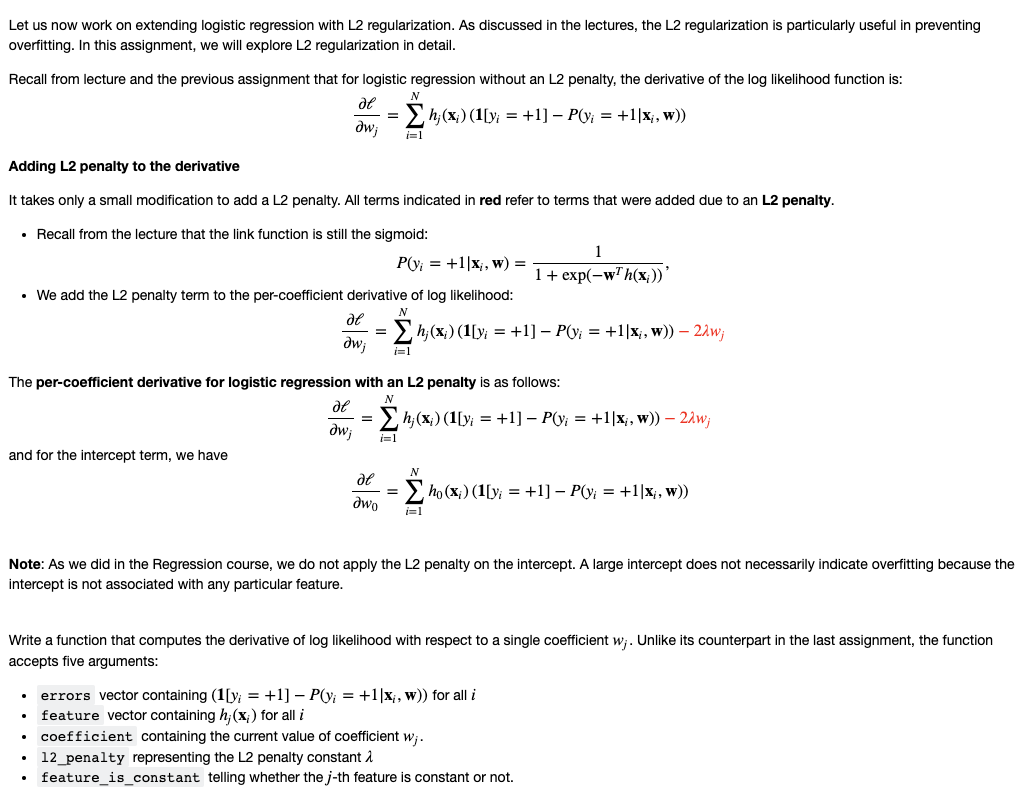

In [21]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
   
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature) 

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant:
        derivative -= (2*l2_penalty*coefficient)
    
    return derivative

**Quiz question: In the code above, was the intercept term regularized?**


To verify the correctness of the gradient descent algorithm, we write a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability), which is given by the formula
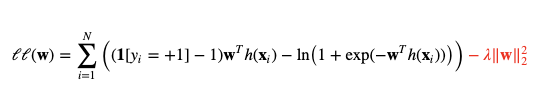

In [22]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

**Quiz question: Does the term with L2 regularization increase or decrease ℓℓ(w)?**

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.

Fill in the code below to complete this modification.

In [23]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            
            coefficients[j] += step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                                        (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

### Explore effects of L2 regularization
Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using L2 regularization in analyzing sentiment for product reviews. As iterations pass, the log likelihood should increase.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [24]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [25]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.73417180
iteration   2: log likelihood of observed labels = -28834.71441858
iteration   3: log likelihood of observed labels = -28671.80345068
iteration   4: log likelihood of observed labels = -28514.58077957
iteration   5: log likelihood of observed labels = -28362.69830317
iteration   6: log likelihood of observed labels = -28215.85663259
iteration   7: log likelihood of observed labels = -28073.79071393
iteration   8: log likelihood of observed labels = -27936.26093762
iteration   9: log likelihood of observed labels = -27803.04751805
iteration  10: log likelihood of observed labels = -27673.94684207
iteration  11: log likelihood of observed labels = -27548.76901327
iteration  12: log likelihood of observed labels = -27427.33612958
iteration  13: log likelihood of observed labels = -27309.48101569
iteration  14: log likelihood of observed labels = -27195.0462

In [26]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.76654163
iteration   2: log likelihood of observed labels = -28834.79322654
iteration   3: log likelihood of observed labels = -28671.94687528
iteration   4: log likelihood of observed labels = -28514.80571589
iteration   5: log likelihood of observed labels = -28363.02048079
iteration   6: log likelihood of observed labels = -28216.29071186
iteration   7: log likelihood of observed labels = -28074.35036891
iteration   8: log likelihood of observed labels = -27936.95892966
iteration   9: log likelihood of observed labels = -27803.89576265
iteration  10: log likelihood of observed labels = -27674.95647005
iteration  11: log likelihood of observed labels = -27549.95042714
iteration  12: log likelihood of observed labels = -27428.69905549
iteration  13: log likelihood of observed labels = -27311.03455140
iteration  14: log likelihood of observed labels = -27196.7989

In [27]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.48385120
iteration   1: log likelihood of observed labels = -29004.25177457
iteration   2: log likelihood of observed labels = -28835.97382190
iteration   3: log likelihood of observed labels = -28674.09410083
iteration   4: log likelihood of observed labels = -28518.17112932
iteration   5: log likelihood of observed labels = -28367.83774654
iteration   6: log likelihood of observed labels = -28222.77708939
iteration   7: log likelihood of observed labels = -28082.70799392
iteration   8: log likelihood of observed labels = -27947.37595368
iteration   9: log likelihood of observed labels = -27816.54738615
iteration  10: log likelihood of observed labels = -27690.00588850
iteration  11: log likelihood of observed labels = -27567.54970126
iteration  12: log likelihood of observed labels = -27448.98991327
iteration  13: log likelihood of observed labels = -27334.14912742
iteration  14: log likelihood of observed labels = -27222.8604

In [28]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29009.07176112
iteration   2: log likelihood of observed labels = -28847.62378912
iteration   3: log likelihood of observed labels = -28695.14439397
iteration   4: log likelihood of observed labels = -28550.95060743
iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.4242

In [29]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29271.71006589
iteration   2: log likelihood of observed labels = -29271.65738833
iteration   3: log likelihood of observed labels = -29271.61189923
iteration   4: log likelihood of observed labels = -29271.57079975
iteration   5: log likelihood of observed labels = -29271.53358505
iteration   6: log likelihood of observed labels = -29271.49988440
iteration   7: log likelihood of observed labels = -29271.46936584
iteration   8: log likelihood of observed labels = -29271.44172890
iteration   9: log likelihood of observed labels = -29271.41670149
iteration  10: log likelihood of observed labels = -29271.39403722
iteration  11: log likelihood of observed labels = -29271.37351294
iteration  12: log likelihood of observed labels = -29271.35492661
iteration  13: log likelihood of observed labels = -29271.33809523
iteration  14: log likelihood of observed labels = -29271.3228

### Compare coefficients
We now compare the coefficients for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [38]:
words = ['INTERCEPT']+important_words
comapringValues = {'words': words,
'0_penalty': coefficients_0_penalty,
'4_penalty': coefficients_4_penalty,
'10_penalty': coefficients_10_penalty, 
'1e2_penalty': coefficients_1e3_penalty,
'1e3_penalty': coefficients_1e3_penalty,
'1e5_penalty': coefficients_1e5_penalty}

In [40]:
comparingValues = pd.DataFrame.from_dict(comapringValues)

In [41]:
comparingValues.head(20)

,words,0_penalty,4_penalty,10_penalty,1e2_penalty,1e3_penalty,1e5_penalty
0,INTERCEPT,-0.063742,-0.063143,-0.062256,0.000054,0.000054,0.011362
1,baby,0.074073,0.073994,0.073877,0.059752,0.059752,0.001784
2,one,0.012753,0.012495,0.012115,-0.008761,-0.008761,-0.001827
3,great,0.801625,0.796897,0.789935,0.376012,0.376012,0.008950
4,love,1.058554,1.050856,1.039529,0.418354,0.418354,0.009042
5,use,-0.000104,0.000163,0.000556,0.017326,0.017326,0.000418
6,would,-0.287021,-0.286027,-0.284564,-0.188662,-0.188662,-0.008127
7,like,-0.003384,-0.003442,-0.003527,-0.007043,-0.007043,-0.000827
8,easy,0.984559,0.977600,0.967362,0.401904,0.401904,0.008808
9,little,0.524419,0.521385,0.516917,0.251221,0.251221,0.005941


Using the coefficients trained with L2 penalty 0, find the 5 most positive words (with largest positive coefficients). Save them to positive_words. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to negative_words.

**Quiz Question. Which of the following is not listed in either positive_words or negative_words?**

In [47]:
positive_words = comparingValues.sort_values('0_penalty', ascending=False).head(5)['words'].values.tolist()

In [49]:
negative_words = comparingValues.sort_values('0_penalty', ascending=True).head(5)['words'].values.tolist()

In [51]:
positive_words

['love', 'loves', 'easy', 'perfect', 'great']

In [50]:
negative_words

['disappointed', 'money', 'return', 'waste', 'returned']

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['words'].isin(positive_words)]
    table_negative_words = table[table['words'].isin(negative_words)]
    del table_positive_words['words']
    del table_negative_words['words']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].values.flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].values.flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

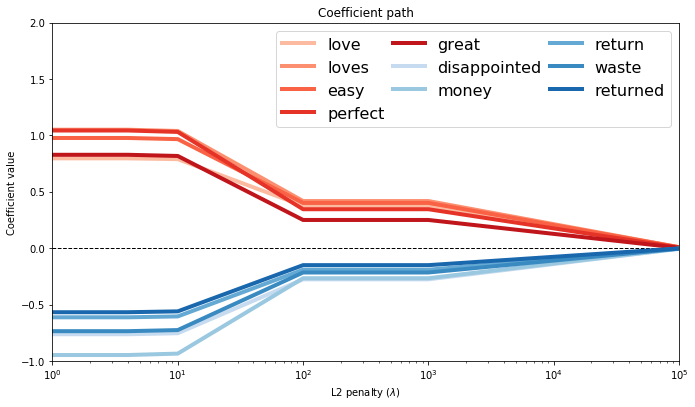

In [58]:

make_coefficient_plot(comparingValues, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

### Measuring accuracy
Quiz question: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the training data? Quiz question: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the validation data? Quiz question: Does the highest accuracy on the training data imply that the model is the best one?

In [59]:
def model_accuaracy(feature_matrix, sentiment, coefficients):
    scores_new = np.dot(feature_matrix, coefficients)
    predictions = np.array([+1 if s > 0 else -1 for s in scores_new])
    num_correct = sum(predictions == sentiment)
    accuracy = float(num_correct) / len(feature_matrix)   
    return accuracy

In [61]:
train_accuracy = {}
validation_accuracy = {}

In [63]:
train_accuracy[0]   = model_accuaracy(feature_matrix_train, sentiment_train, comparingValues['0_penalty'].values)
train_accuracy[4]   = model_accuaracy(feature_matrix_train, sentiment_train, comparingValues['4_penalty'].values)
train_accuracy[10]  = model_accuaracy(feature_matrix_train, sentiment_train, comparingValues['10_penalty'].values)
train_accuracy[1e2] = model_accuaracy(feature_matrix_train, sentiment_train, comparingValues['1e2_penalty'].values)
train_accuracy[1e3] = model_accuaracy(feature_matrix_train, sentiment_train, comparingValues['1e3_penalty'].values)
train_accuracy[1e5] = model_accuaracy(feature_matrix_train, sentiment_train, comparingValues['1e5_penalty'].values)


validation_accuracy[0]   = model_accuaracy(feature_matrix_valid, sentiment_valid, comparingValues['0_penalty'].values)
validation_accuracy[4]   = model_accuaracy(feature_matrix_valid, sentiment_valid, comparingValues['4_penalty'].values)
validation_accuracy[10]  = model_accuaracy(feature_matrix_valid, sentiment_valid, comparingValues['10_penalty'].values)
validation_accuracy[1e2] = model_accuaracy(feature_matrix_valid, sentiment_valid, comparingValues['1e2_penalty'].values)
validation_accuracy[1e3] = model_accuaracy(feature_matrix_valid, sentiment_valid, comparingValues['1e3_penalty'].values)
validation_accuracy[1e5] = model_accuaracy(feature_matrix_valid, sentiment_valid, comparingValues['1e5_penalty'].values)

In [64]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print ("L2 penalty = %g" % key)
    print ("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print ("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.7851561577866434, validation_accuracy = 0.781439641490057
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.7851089445480512, validation_accuracy = 0.7815330034543927
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.7849909114515711, validation_accuracy = 0.7817197273830642
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7758551497839994, validation_accuracy = 0.7713565493417982
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.7758551497839994, validation_accuracy = 0.7713565493417982
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.6803663747314747, validation_accuracy = 0.667818130893474
----------------------------